In [1]:
import glob
import os
import librosa
import numpy as np
import seaborn as sns
import wave
import contextlib
import pandas as pd

from sklearn.metrics import accuracy_score,classification_report,f1_score
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
%matplotlib inline
plt.style.use('ggplot')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.titlesize'] = 13

In [2]:
s = "02 Eow_peacock_2.WAV"
s.split("_")
#print(fn.split('_')[-1]=='2.WAV')

['02 Eow', 'peacock', '2.WAV']

# Features plots - Code

In [3]:
def load_sound_files(file_paths):
    raw_sounds = []
    for fp in file_paths:
        X,sr = librosa.load(fp)
        raw_sounds.append(X)
    return raw_sounds

def plot_waves(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25,60), dpi = 900)
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        librosa.display.waveplot(np.array(f),sr=22050)
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 1: Waveplot',x=0.5, y=0.915,fontsize=18)
    plt.show()
    
def plot_specgram(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25,60), dpi = 900)
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        specgram(np.array(f), Fs=22050)
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 2: Spectrogram',x=0.5, y=0.915,fontsize=18)
    plt.show()

def plot_log_power_specgram(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25,60), dpi = 900)
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        D = librosa.logamplitude(np.abs(librosa.stft(f))**2, ref_power=np.max)
        librosa.display.specshow(D,x_axis='time' ,y_axis='log')
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 3: Log power spectrogram',x=0.5, y=0.915,fontsize=18)
    plt.show()

# Extracting features

In [4]:
def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    #print(chroma.shape)
    #print("chroma")
    #print(mfccs.shape)
    #print("mfccs")
    #print(mel.shape)
    #print("mels")
    #print(contrast.shape)
    #print("contrast")
    #print(tonnetz.shape)
    #print("tonnetz")    
    return mfccs,chroma,mel,contrast,tonnetz

def parse_audio_files(parent_dir,sub_dirs,file_ext='*.wav'):
    d=0
    duration1 = []
    duration2 = []
    for label, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir,sub_dir,file_ext)):
            with contextlib.closing(wave.open(fn,'r')) as f:
                frames = f.getnframes()
                rate = f.getframerate()
                duration = frames / float(rate)
                print(pd.Series(fn.split('_')).unique())
                print(d,duration)
                d=d+1
                print(" ")
                #dn=0
                if(sub_dir!='noise_set'):
                    #if(duration<0):
                    #    dn =dn+1
                    duration1.append(duration)  
                else:
                    duration2.append(duration)
            
    return duration1,duration2

In [5]:
def parse_audio_files2(parent_dir,sub_dirs,file_ext='*.wav'):
    features = np.empty((0,193))
    finlabel = np.empty((0,3))
    labells=[]
    labells1=np.empty(0) 
    labells2=np.empty(0) 
    d=0
    fns = []
    labels=[]
    label1s=[]
    label2s=[]
    for label, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir,sub_dir,file_ext)):
            mfccs, chroma, mel, contrast,tonnetz = extract_feature(fn)
            ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
          #  print("ext_features")
          #  print(ext_features.shape)
            features = np.vstack([features,ext_features])
          #  print("features")
          #  print(features.shape)
            if(sub_dir!='noise_set'):
                    d = d+1
                    if (len(fn.split('_'))>=6):
                        label1 = "1"
                    else:
                        label1="0"
                    label="1"
                    if(sub_dir=='TRIM_old' or sub_dir=='extra_mp3'):
                        if(fn.split('_')[-1]=='2.wav'or fn.split('_')[-1]=='2.WAV'):
                            label2="2"
                        if(fn.split('_')[-1]=='3.wav'or fn.split('_')[-1]=='3.WAV'):
                            label2="3"   
                        if(fn.split('_')[-1]=='1.wav'or fn.split('_')[-1]=='1.WAV'):
                            label2="1"
                        if(fn.split('_')[-1]=='MI.wav'or fn.split('_')[-1]=='MI.WAV'):
                            label2="4"
                        if(fn.split('_')[3]=='Multiplepeacock'):
                            label2 = "4"
                        else:
                            label2 ="1"
                    else:
                        if(fn.split('_')[-1]=='1.wav'):
                            label2="1"
                        elif(fn.split('_')[-1]=='2.wav'):
                            label2 ="2" 
                        elif(fn.split('_')[-1]=='3.wav'):
                            label2 ="3"
                        elif(fn.split('_')[-1]=='MI.wav' or fn.split('_')[-1]=='3or4.wav'):
                            label2 ="4"                        
                        else:
                            label2 ="0"
                            
            else:
                label ="0"
                label1="1"
                label2 ="0"
            fns.append(fn.split('_')[1:])
            use = np.hstack([label,label1,label2])
            finlabel = np.vstack([finlabel,use])
            labels.append(label)
            label1s.append(label1)
            label2s.append(label2)
    return(fns, np.array(features), np.array(finlabel),np.array(labels), np.array(label1s), np.array(label2s))

> #  Feed Train & Test Data 

In [6]:
parent_dir = '../input/data-w/data/data'

sub_dirs = ['C_new2','TRIM_old','A_new1','trimmed_new3','noise_set','Chincholi','iid','Kaan'] #train dirs
duration1,duration2= parse_audio_files(parent_dir,sub_dirs)

['../input/data-w/data/data/C' 'new2/20' 'SN' 'peacock' '1.wav']
0 0.35421875
 
['../input/data-w/data/data/C' 'new2/28' 'keow(b)' 'peacock' '1.wav']
1 0.5195
 
['../input/data-w/data/data/C' 'new2/24' ' Eow' 'peacock' 'disturbance'
 '2.wav']
2 5.87215625
 
['../input/data-w/data/data/C' 'new2/25' 'SN' 'peacock' 'disturbance'
 '2.wav']
3 0.34634375
 
['../input/data-w/data/data/C' 'new2/01' 'Eow' 'peacock' 'disturbance'
 '2.wav']
4 0.7433125
 
['../input/data-w/data/data/C' 'new2/03' 'SN' 'peacock' 'disturbance'
 '2.wav']
5 0.36378125
 
['../input/data-w/data/data/C' 'new2/06' 'SN' 'peacock' 'disturbance'
 '2.wav']
6 0.40828125
 
['../input/data-w/data/data/C' 'new2/35' 'Eow' 'peacock' 'disturbance'
 '2.wav']
7 6.885625
 
['../input/data-w/data/data/C' 'new2/33' 'Eow' 'peacock' '1.wav']
8 0.60415625
 
['../input/data-w/data/data/C' 'new2/17' 'Eow' 'peacock' 'disturbance'
 '2.wav']
9 7.5035625
 
['../input/data-w/data/data/C' 'new2/20' 'Eow' 'peacock' 'disturbance'
 '2.wav']
10 4.841
 


['../input/data-w/data/data/noise' 'set/4-171706-A-23.wav']
126 5.0
 
['../input/data-w/data/data/noise' 'set/5-257349-A-15.wav']
127 5.0
 
['../input/data-w/data/data/noise' 'set/2-250710-A-39.wav']
128 5.0
 
['../input/data-w/data/data/noise' 'set/3-148330-A-21.wav']
129 5.0
 
['../input/data-w/data/data/noise' 'set/4-121532-A-42.wav']
130 5.0
 
['../input/data-w/data/data/noise' 'set/2-103424-A-3.wav']
131 5.0
 
['../input/data-w/data/data/noise' 'set/2-95035-A-1.wav']
132 5.0
 
['../input/data-w/data/data/noise' 'set/2-85139-A-13.wav']
133 5.0
 
['../input/data-w/data/data/noise' 'set/2-116400-A-0.wav']
134 5.0
 
['../input/data-w/data/data/noise' 'set/2-152964-A-31.wav']
135 5.0
 
['../input/data-w/data/data/noise' 'set/3-110913-C-7.wav']
136 5.0
 
['../input/data-w/data/data/noise' 'set/4-99193-A-4.wav']
137 5.0
 
['../input/data-w/data/data/noise' 'set/5-244933-A-34.wav']
138 5.0
 
['../input/data-w/data/data/noise' 'set/1-67432-A-27.wav']
139 5.0
 
['../input/data-w/data/data/n

['../input/data-w/data/data/noise' 'set/4-194981-A-25.wav']
245 5.0
 
['../input/data-w/data/data/noise' 'set/4-160036-B-33.wav']
246 5.0
 
['../input/data-w/data/data/noise' 'set/3-151269-A-35.wav']
247 5.0
 
['../input/data-w/data/data/noise' 'set/4-188287-A-9.wav']
248 5.0
 
['../input/data-w/data/data/noise' 'set/1-7973-A-7.wav']
249 5.0
 
['../input/data-w/data/data/noise' 'set/3-156393-A-35.wav']
250 5.0
 
['../input/data-w/data/data/noise' 'set/5-243025-A-25.wav']
251 5.0
 
['../input/data-w/data/data/noise' 'set/2-43806-A-42.wav']
252 5.0
 
['../input/data-w/data/data/noise' 'set/3-104761-B-7.wav']
253 5.0
 
['../input/data-w/data/data/noise' 'set/1-260640-C-2.wav']
254 5.0
 
['../input/data-w/data/data/noise' 'set/5-251489-A-24.wav']
255 5.0
 
['../input/data-w/data/data/noise' 'set/1-61534-A-27.wav']
256 5.0
 
['../input/data-w/data/data/noise' 'set/2-73544-A-27.wav']
257 5.0
 
['../input/data-w/data/data/noise' 'set/4-156843-A-21.wav']
258 5.0
 
['../input/data-w/data/data/n

['../input/data-w/data/data/noise' 'set/3-127890-C-9.wav']
369 5.0
 
['../input/data-w/data/data/noise' 'set/1-43382-A-1.wav']
370 5.0
 
['../input/data-w/data/data/noise' 'set/4-165606-A-45.wav']
371 5.0
 
['../input/data-w/data/data/noise' 'set/3-117293-A-9.wav']
372 5.0
 
['../input/data-w/data/data/noise' 'set/4-161579-B-40.wav']
373 5.0
 
['../input/data-w/data/data/noise' 'set/3-141684-A-21.wav']
374 5.0
 
['../input/data-w/data/data/noise' 'set/4-170247-B-12.wav']
375 5.0
 
['../input/data-w/data/data/noise' 'set/2-124564-A-15.wav']
376 5.0
 
['../input/data-w/data/data/noise' 'set/2-134049-A-6.wav']
377 5.0
 
['../input/data-w/data/data/noise' 'set/2-64332-A-18.wav']
378 5.0
 
['../input/data-w/data/data/noise' 'set/3-180977-A-0.wav']
379 5.0
 
['../input/data-w/data/data/noise' 'set/3-188390-A-6.wav']
380 5.0
 
['../input/data-w/data/data/noise' 'set/5-260011-A-34.wav']
381 5.0
 
['../input/data-w/data/data/noise' 'set/5-187201-B-4.wav']
382 5.0
 
['../input/data-w/data/data/n

['../input/data-w/data/data/noise' 'set/5-177034-A-18.wav']
492 5.0
 
['../input/data-w/data/data/noise' 'set/1-208757-E-2.wav']
493 5.0
 
['../input/data-w/data/data/noise' 'set/3-144827-A-11.wav']
494 5.0
 
['../input/data-w/data/data/noise' 'set/1-36164-A-26.wav']
495 5.0
 
['../input/data-w/data/data/noise' 'set/4-253649-A-6.wav']
496 5.0
 
['../input/data-w/data/data/noise' 'set/1-60676-A-34.wav']
497 5.0
 
['../input/data-w/data/data/noise' 'set/1-20133-A-39.wav']
498 5.0
 
['../input/data-w/data/data/noise' 'set/4-157611-B-41.wav']
499 5.0
 
['../input/data-w/data/data/noise' 'set/5-205589-A-17.wav']
500 5.0
 
['../input/data-w/data/data/noise' 'set/3-165856-A-41.wav']
501 5.0
 
['../input/data-w/data/data/noise' 'set/4-195305-A-31.wav']
502 5.0
 
['../input/data-w/data/data/noise' 'set/1-56380-B-5.wav']
503 5.0
 
['../input/data-w/data/data/noise' 'set/2-106849-A-47.wav']
504 5.0
 
['../input/data-w/data/data/noise' 'set/2-114609-A-28.wav']
505 5.0
 
['../input/data-w/data/data

['../input/data-w/data/data/noise' 'set/3-103401-B-33.wav']
612 5.0
 
['../input/data-w/data/data/noise' 'set/4-202298-A-31.wav']
613 5.0
 
['../input/data-w/data/data/noise' 'set/1-69422-A-3.wav']
614 5.0
 
['../input/data-w/data/data/noise' 'set/5-207811-B-35.wav']
615 5.0
 
['../input/data-w/data/data/noise' 'set/3-142005-A-10.wav']
616 5.0
 
['../input/data-w/data/data/noise' 'set/1-88807-A-39.wav']
617 5.0
 
['../input/data-w/data/data/noise' 'set/5-208810-B-11.wav']
618 5.0
 
['../input/data-w/data/data/noise' 'set/1-19898-B-41.wav']
619 5.0
 
['../input/data-w/data/data/noise' 'set/2-188822-B-40.wav']
620 5.0
 
['../input/data-w/data/data/noise' 'set/2-119161-C-8.wav']
621 5.0
 
['../input/data-w/data/data/noise' 'set/2-37806-A-40.wav']
622 5.0
 
['../input/data-w/data/data/noise' 'set/3-132747-A-26.wav']
623 5.0
 
['../input/data-w/data/data/noise' 'set/2-117795-B-3.wav']
624 5.0
 
['../input/data-w/data/data/noise' 'set/1-17742-A-12.wav']
625 5.0
 
['../input/data-w/data/data/

['../input/data-w/data/data/noise' 'set/4-187504-A-17.wav']
732 5.0
 
['../input/data-w/data/data/noise' 'set/1-32373-B-35.wav']
733 5.0
 
['../input/data-w/data/data/noise' 'set/2-99955-B-7.wav']
734 5.0
 
['../input/data-w/data/data/noise' 'set/2-92627-A-27.wav']
735 5.0
 
['../input/data-w/data/data/noise' 'set/3-158476-A-12.wav']
736 5.0
 
['../input/data-w/data/data/noise' 'set/3-102583-B-49.wav']
737 5.0
 
['../input/data-w/data/data/noise' 'set/4-261068-A-30.wav']
738 5.0
 
['../input/data-w/data/data/noise' 'set/1-24074-A-43.wav']
739 5.0
 
['../input/data-w/data/data/noise' 'set/3-182710-B-35.wav']
740 5.0
 
['../input/data-w/data/data/noise' 'set/1-56233-A-9.wav']
741 5.0
 
['../input/data-w/data/data/noise' 'set/5-232802-A-31.wav']
742 5.0
 
['../input/data-w/data/data/noise' 'set/5-179865-A-43.wav']
743 5.0
 
['../input/data-w/data/data/noise' 'set/1-72229-B-6.wav']
744 5.0
 
['../input/data-w/data/data/noise' 'set/2-144031-A-34.wav']
745 5.0
 
['../input/data-w/data/data/n

['../input/data-w/data/data/noise' 'set/4-171652-A-44.wav']
887 5.0
 
['../input/data-w/data/data/noise' 'set/5-198278-C-7.wav']
888 5.0
 
['../input/data-w/data/data/noise' 'set/3-151081-A-20.wav']
889 5.0
 
['../input/data-w/data/data/noise' 'set/4-154405-B-27.wav']
890 5.0
 
['../input/data-w/data/data/noise' 'set/3-156558-A-21.wav']
891 5.0
 
['../input/data-w/data/data/noise' 'set/1-23222-A-19.wav']
892 5.0
 
['../input/data-w/data/data/noise' 'set/2-119102-A-21.wav']
893 5.0
 
['../input/data-w/data/data/noise' 'set/5-188655-A-10.wav']
894 5.0
 
['../input/data-w/data/data/noise' 'set/4-204618-A-11.wav']
895 5.0
 
['../input/data-w/data/data/noise' 'set/1-172649-E-40.wav']
896 5.0
 
['../input/data-w/data/data/noise' 'set/5-199284-A-45.wav']
897 5.0
 
['../input/data-w/data/data/noise' 'set/2-51630-A-49.wav']
898 5.0
 
['../input/data-w/data/data/noise' 'set/5-204741-A-46.wav']
899 5.0
 
['../input/data-w/data/data/noise' 'set/3-128160-A-44.wav']
900 5.0
 
['../input/data-w/data/

['../input/data-w/data/data/noise' 'set/3-98869-A-46.wav']
1007 5.0
 
['../input/data-w/data/data/noise' 'set/4-165845-B-45.wav']
1008 5.0
 
['../input/data-w/data/data/noise' 'set/2-209472-A-25.wav']
1009 5.0
 
['../input/data-w/data/data/noise' 'set/4-172500-B-27.wav']
1010 5.0
 
['../input/data-w/data/data/noise' 'set/4-108352-A-33.wav']
1011 5.0
 
['../input/data-w/data/data/noise' 'set/5-220939-A-27.wav']
1012 5.0
 
['../input/data-w/data/data/noise' 'set/4-80761-A-42.wav']
1013 5.0
 
['../input/data-w/data/data/noise' 'set/2-83688-A-34.wav']
1014 5.0
 
['../input/data-w/data/data/noise' 'set/4-168446-A-45.wav']
1015 5.0
 
['../input/data-w/data/data/noise' 'set/5-234335-A-23.wav']
1016 5.0
 
['../input/data-w/data/data/noise' 'set/1-38560-A-14.wav']
1017 5.0
 
['../input/data-w/data/data/noise' 'set/5-232272-A-44.wav']
1018 5.0
 
['../input/data-w/data/data/noise' 'set/1-17092-B-27.wav']
1019 5.0
 
['../input/data-w/data/data/noise' 'set/4-196671-B-8.wav']
1020 5.0
 
['../input/d

['../input/data-w/data/data/noise' 'set/3-163607-A-13.wav']
1130 5.0
 
['../input/data-w/data/data/noise' 'set/5-234879-B-1.wav']
1131 5.0
 
['../input/data-w/data/data/noise' 'set/1-47714-A-16.wav']
1132 5.0
 
['../input/data-w/data/data/noise' 'set/3-129678-A-13.wav']
1133 5.0
 
['../input/data-w/data/data/noise' 'set/4-161099-A-47.wav']
1134 5.0
 
['../input/data-w/data/data/noise' 'set/1-79113-A-5.wav']
1135 5.0
 
['../input/data-w/data/data/noise' 'set/3-167096-A-31.wav']
1136 5.0
 
['../input/data-w/data/data/noise' 'set/4-191246-B-7.wav']
1137 5.0
 
['../input/data-w/data/data/noise' 'set/4-180453-A-17.wav']
1138 5.0
 
['../input/data-w/data/data/noise' 'set/4-182034-A-30.wav']
1139 5.0
 
['../input/data-w/data/data/noise' 'set/5-263831-A-6.wav']
1140 5.0
 
['../input/data-w/data/data/noise' 'set/3-122110-A-46.wav']
1141 5.0
 
['../input/data-w/data/data/noise' 'set/4-125825-A-46.wav']
1142 5.0
 
['../input/data-w/data/data/noise' 'set/4-198965-A-38.wav']
1143 5.0
 
['../input/d

In [8]:
dafr = pd.DataFrame()
dafr["peacock_audio_durations"] = pd.Series(duration1)
dafr["noise_durations"] = pd.Series(duration2)

# Data Distribution

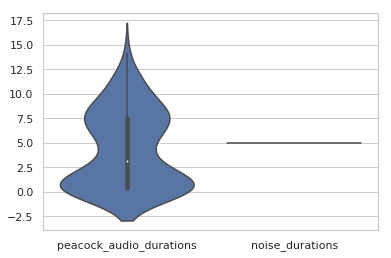

In [9]:
sns.set(style="whitegrid")
ax = sns.violinplot(data=dafr)

In [11]:
fn,features,final_labels,label,label1,label2 = parse_audio_files2(parent_dir,sub_dirs)

/opt/conda/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


In [12]:
final_labels.shape

(1242, 3)

In [13]:
from sklearn.preprocessing import MultiLabelBinarizer,LabelBinarizer
from numpy import argmax
from keras.utils import to_categorical
from keras import initializers

one_hot1 = LabelBinarizer()
# One-hot encode data
label_ = one_hot1.fit_transform(label)
label_1 = one_hot1.fit_transform(label1)
#print(one_hot1.classes_)print(label_)print(label_1)
one_hot2 = MultiLabelBinarizer()
# One-hot encode data
label_2 = one_hot2.fit_transform(label2)
label__2 = to_categorical(label2)
#print(label__2)
one_hot2.classes_

Using TensorFlow backend.


array(['0', '1', '2', '3', '4'], dtype=object)

In [14]:
print(label__2.shape)
print(label_1.shape)
print(label_.shape)
print(label_2.shape)

(1242, 5)
(1242, 1)
(1242, 1)
(1242, 5)


In [15]:
dafr_labels = pd.DataFrame()
dafr_labels["file_name"] = fn
dafr_labels["peacock"] = label_
dafr_labels["disturbance"] = label_1
#dafr_labels["single_peacock"] = [label__2]

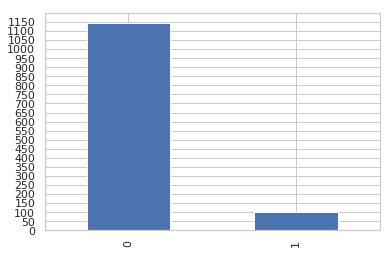

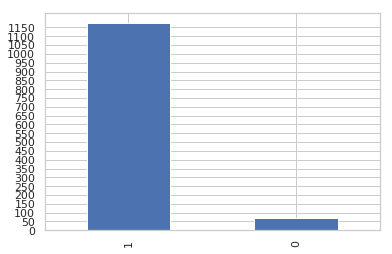

In [16]:
dafr_labels['peacock'].value_counts().plot(kind='bar')
            #,'disturbance','single_peacock']].plot(kind='bar')
#plt.xticks(np.arange(0, 51, 5)) 
plt.yticks(np.arange(0, 1200, 50)) 
plt.show()
dafr_labels['disturbance'].value_counts().plot(kind='bar')
plt.yticks(np.arange(0, 1200, 50)) 
plt.show()
#dafr_labels['single_peacock'].value_counts().plot(kind='bar')
#plt.yticks(np.arange(0, 1200, 25)) 
#plt.show()

In [17]:
pd.Series(label).value_counts()

0    1143
1      99
dtype: int64

In [18]:
pd.Series(label1).value_counts()

1    1174
0      68
dtype: int64

In [19]:
pd.Series(label2).value_counts()

0    1146
1      48
2      41
4       4
3       3
dtype: int64

# MLP keras 

In [20]:
import keras 
from keras.models import Sequential
from keras.layers import Dense, Activation,Flatten, Dropout
from keras.layers.normalization import BatchNormalization


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPooling2D
#from keras import regularizers, optimizer
import pandas as pd
import random
import tensorflow as tf
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,multilabel_confusion_matrix
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from keras import backend as K
random.seed(42)
np.random.seed(42)
tf.set_random_seed(42)

my_init = initializers.glorot_uniform(seed=42)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [21]:
X_train, X_test, y1_train, y1_test,y2_train,y2_test,y3_train,y3_test = train_test_split(features,
                                            label_,label_1,label__2, test_size=0.33, random_state=42)

In [22]:
print(y3_train.shape)
print(y3_test.shape)

(832, 5)
(410, 5)


## Multi output neural network

In [23]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [24]:
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

In [25]:
#create the model
inn = Input(shape = (193,))
x = Sequential()(inn)
# Adding the input layer and the first hidden layer
x = Dense(output_dim = 40, init = 'uniform', activation = 'relu', input_dim = 193)(x)
x=BatchNormalization()(x)
x = (Dropout(0.2))(x)
# Adding the second hidden layer
x=Dense(output_dim = 20, init = 'uniform', activation = 'relu')(x)
x=BatchNormalization()(x)
x = (Dropout(0.2))(x)

x= Dense(output_dim = 8, init = 'uniform', activation = 'relu')(x)
x=BatchNormalization()(x)
x = (Dropout(0.2))(x)
# Adding the output layer
out1 =Dense(output_dim = 1, init = 'uniform', activation = 'sigmoid')(x)
out2 =Dense(output_dim = 1, init = 'uniform', activation = 'sigmoid')(x)
out3 =Dense(output_dim = 5, init = 'uniform', activation = 'softmax')(x)
# Compiling Neural Network
model = Model(inputs=[inn], outputs=[out1, out2,out3])
#classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
# compile the model
model.compile(optimizer='adam', loss=['binary_crossentropy','binary_crossentropy','categorical_crossentropy'],
              metrics=[f1_m,f1_m,f1_m])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=193, units=40, kernel_initializer="uniform")`
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=20, kernel_initializer="uniform")`
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=8, kernel_initializer="uniform")`
  del sys.path[0]
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1, kernel_initializer="uniform")`
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1, kernel_initi

In [26]:
class_weights = {0: 1.08377,
                1: 25.875,
                2: 30.3,
                3: 414,
                4: 310.5} # w(i) = N/n(i)
cw1 = {0:1.,
       1:10.} 
cw2 = {0:10.,
       1:1.} 

In [27]:
# fit the model
history = model.fit(X_train, [y1_train,y2_train,y3_train],
                    validation_split=0.3, epochs=100,batch_size = 10, verbose=1,
                    class_weight=[cw1,cw2,class_weights])
                    #{'out1':cw1,'ou2t':cw2,'out3':class_weights})

Train on 582 samples, validate on 250 samples
Epoch 1/100
582/582 [==============================] - 2s 3ms/step - loss: 10.0809 - dense_4_loss: 1.1519 - dense_5_loss: 1.0012 - dense_6_loss: 7.8334 - dense_4_f1_m: 0.2067 - dense_5_f1_m: 0.6651 - dense_6_f1_m: 0.0000e+00 - val_loss: 11.4032 - val_dense_4_loss: 1.1406 - val_dense_5_loss: 1.0374 - val_dense_6_loss: 9.2253 - val_dense_4_f1_m: 0.0000e+00 - val_dense_5_f1_m: 0.9694 - val_dense_6_f1_m: 0.0000e+00
Epoch 2/100
582/582 [==============================] - 1s 1ms/step - loss: 9.6669 - dense_4_loss: 1.1072 - dense_5_loss: 0.9717 - dense_6_loss: 7.4962 - dense_4_f1_m: 0.2354 - dense_5_f1_m: 0.7059 - dense_6_f1_m: 0.0000e+00 - val_loss: 11.3877 - val_dense_4_loss: 1.1356 - val_dense_5_loss: 1.0307 - val_dense_6_loss: 9.2214 - val_dense_4_f1_m: 0.0000e+00 - val_dense_5_f1_m: 0.9694 - val_dense_6_f1_m: 0.0000e+00
Epoch 3/100
582/582 [==============================] - 1s 984us/step - loss: 9.1311 - dense_4_loss: 1.0410 - dense_5_loss: 0.

582/582 [==============================] - 1s 1ms/step - loss: 5.0487 - dense_4_loss: 0.4689 - dense_5_loss: 0.4467 - dense_6_loss: 4.0846 - dense_4_f1_m: 0.4542 - dense_5_f1_m: 0.9348 - dense_6_f1_m: 0.6293 - val_loss: 9.7749 - val_dense_4_loss: 0.3834 - val_dense_5_loss: 0.4453 - val_dense_6_loss: 8.9462 - val_dense_4_f1_m: 0.4400 - val_dense_5_f1_m: 0.9824 - val_dense_6_f1_m: 0.8808
Epoch 22/100
582/582 [==============================] - 1s 977us/step - loss: 4.9204 - dense_4_loss: 0.4495 - dense_5_loss: 0.4650 - dense_6_loss: 3.9644 - dense_4_f1_m: 0.4757 - dense_5_f1_m: 0.9343 - dense_6_f1_m: 0.6607 - val_loss: 9.9789 - val_dense_4_loss: 0.4520 - val_dense_5_loss: 0.5118 - val_dense_6_loss: 9.0150 - val_dense_4_f1_m: 0.4400 - val_dense_5_f1_m: 0.9848 - val_dense_6_f1_m: 0.8480
Epoch 23/100
582/582 [==============================] - 1s 1ms/step - loss: 5.0781 - dense_4_loss: 0.4686 - dense_5_loss: 0.4344 - dense_6_loss: 4.1240 - dense_4_f1_m: 0.4588 - dense_5_f1_m: 0.9436 - dense_6

582/582 [==============================] - 1s 1ms/step - loss: 4.0895 - dense_4_loss: 0.3414 - dense_5_loss: 0.3755 - dense_6_loss: 3.3400 - dense_4_f1_m: 0.4744 - dense_5_f1_m: 0.9534 - dense_6_f1_m: 0.8199 - val_loss: 10.4961 - val_dense_4_loss: 0.3112 - val_dense_5_loss: 0.4020 - val_dense_6_loss: 9.7829 - val_dense_4_f1_m: 0.4133 - val_dense_5_f1_m: 0.9803 - val_dense_6_f1_m: 0.9474
Epoch 42/100
582/582 [==============================] - 1s 1ms/step - loss: 4.2389 - dense_4_loss: 0.3858 - dense_5_loss: 0.3507 - dense_6_loss: 3.4695 - dense_4_f1_m: 0.5040 - dense_5_f1_m: 0.9463 - dense_6_f1_m: 0.8133 - val_loss: 10.8309 - val_dense_4_loss: 0.3181 - val_dense_5_loss: 0.3639 - val_dense_6_loss: 10.1489 - val_dense_4_f1_m: 0.4027 - val_dense_5_f1_m: 0.9735 - val_dense_6_f1_m: 0.8534
Epoch 43/100
582/582 [==============================] - 1s 999us/step - loss: 4.4038 - dense_4_loss: 0.3786 - dense_5_loss: 0.3624 - dense_6_loss: 3.6224 - dense_4_f1_m: 0.5023 - dense_5_f1_m: 0.9516 - dens

582/582 [==============================] - 1s 990us/step - loss: 4.1515 - dense_4_loss: 0.3237 - dense_5_loss: 0.3365 - dense_6_loss: 3.4472 - dense_4_f1_m: 0.4853 - dense_5_f1_m: 0.9608 - dense_6_f1_m: 0.8233 - val_loss: 11.6773 - val_dense_4_loss: 0.3356 - val_dense_5_loss: 0.4589 - val_dense_6_loss: 10.8829 - val_dense_4_f1_m: 0.4133 - val_dense_5_f1_m: 0.9759 - val_dense_6_f1_m: 0.9499
Epoch 62/100
582/582 [==============================] - 1s 996us/step - loss: 4.6740 - dense_4_loss: 0.3376 - dense_5_loss: 0.3365 - dense_6_loss: 3.9591 - dense_4_f1_m: 0.5367 - dense_5_f1_m: 0.9629 - dense_6_f1_m: 0.8249 - val_loss: 10.1461 - val_dense_4_loss: 0.4554 - val_dense_5_loss: 0.5356 - val_dense_6_loss: 9.1550 - val_dense_4_f1_m: 0.3600 - val_dense_5_f1_m: 0.9759 - val_dense_6_f1_m: 0.9394
Epoch 63/100
582/582 [==============================] - 1s 981us/step - loss: 4.4418 - dense_4_loss: 0.3692 - dense_5_loss: 0.3469 - dense_6_loss: 3.6893 - dense_4_f1_m: 0.4944 - dense_5_f1_m: 0.9511 - 

582/582 [==============================] - 1s 1ms/step - loss: 4.1680 - dense_4_loss: 0.3397 - dense_5_loss: 0.3568 - dense_6_loss: 3.4205 - dense_4_f1_m: 0.4605 - dense_5_f1_m: 0.9570 - dense_6_f1_m: 0.8507 - val_loss: 11.8484 - val_dense_4_loss: 0.2768 - val_dense_5_loss: 0.3773 - val_dense_6_loss: 11.1942 - val_dense_4_f1_m: 0.4533 - val_dense_5_f1_m: 0.9848 - val_dense_6_f1_m: 0.9385
Epoch 82/100
582/582 [==============================] - 1s 967us/step - loss: 3.8491 - dense_4_loss: 0.2768 - dense_5_loss: 0.2653 - dense_6_loss: 3.2697 - dense_4_f1_m: 0.5559 - dense_5_f1_m: 0.9580 - dense_6_f1_m: 0.8582 - val_loss: 11.3579 - val_dense_4_loss: 0.2716 - val_dense_5_loss: 0.3670 - val_dense_6_loss: 10.7193 - val_dense_4_f1_m: 0.4133 - val_dense_5_f1_m: 0.9824 - val_dense_6_f1_m: 0.9544
Epoch 83/100
582/582 [==============================] - 1s 999us/step - loss: 3.6991 - dense_4_loss: 0.2726 - dense_5_loss: 0.2629 - dense_6_loss: 3.1262 - dense_4_f1_m: 0.5390 - dense_5_f1_m: 0.9715 - d

In [28]:
# evaluate the model
f1score = model.evaluate(X_test, [y1_test,y2_test,y3_test])
#classifier =KerasClassifier(build_fn=making_model(193), epochs=100, batch_size=10, verbose=0)

410/410 [==============================] - 0s 100us/step


In [29]:
f1score

[0.4752868788998301,
 0.08234787732362747,
 0.10622140020132065,
 0.2854807674884796,
 0.7038729786872864,
 0.9776144623756409,
 0.9295616149902344]

In [30]:
yy1,yy2,yy3 = model.predict(X_test)

In [31]:
shape = yy3.shape
for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        if yy3[i, j] >= 0.5:
            yy3[i, j] = 1
        else:
            yy3[i, j] = 0
for i in range(0, shape[0]):
        if yy2[i, 0] >= 0.5:
            yy2[i, 0] = 1
        else:
            yy2[i, 0] = 0
for i in range(0, shape[0]):
        if yy1[i, 0] >= 0.5:
            yy1[i, 0] = 1
        else:
            yy1[i, 0] = 0     


In [32]:
res_pred=np.empty(shape=(len(yy3),1),dtype=int)
res_ex = np.empty(shape=(len(yy3),1),dtype=int)

In [33]:
for i in range(len(yy3)):
    res_pred[i] = argmax(yy3[i])
    res_ex[i] = argmax(y3_test[i])
    #print(argmax(yy3[i]))
    #print(y3_test[i])
    #print("--------------------------------------------")

In [34]:
print(confusion_matrix(y1_test,yy1))
print(classification_report(y1_test,yy1))

[[374   1]
 [ 10  25]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       375
           1       0.96      0.71      0.82        35

    accuracy                           0.97       410
   macro avg       0.97      0.86      0.90       410
weighted avg       0.97      0.97      0.97       410



In [35]:
print(confusion_matrix(y2_test,yy2))
print(classification_report(y2_test,yy2))

[[ 14   8]
 [  9 379]]
              precision    recall  f1-score   support

           0       0.61      0.64      0.62        22
           1       0.98      0.98      0.98       388

    accuracy                           0.96       410
   macro avg       0.79      0.81      0.80       410
weighted avg       0.96      0.96      0.96       410



In [36]:
confusion_matrix(res_ex,res_pred)

array([[371,   0,   0,   6,   0],
       [ 13,   0,   0,   0,   0],
       [ 17,   0,   0,   1,   0],
       [  0,   0,   0,   0,   0],
       [  2,   0,   0,   0,   0]])

In [37]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 193)          0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 193)          0           input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 40)           7760        sequential_1[1][0]               
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 40)           160         dense_1[0][0]                    
____________________________________________________________________________________________

In [38]:
print(f1_score(res_ex,res_pred,average='weighted'))
print(precision_score(res_ex,res_pred,average='weighted'))
print(recall_score(res_ex,res_pred,average='weighted'))

0.8747154471544717
0.8464988198269079
0.9048780487804878


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [39]:
print(f1_score(res_ex,res_pred,average='micro'))
print(precision_score(res_ex,res_pred,average='micro'))
print(recall_score(res_ex,res_pred,average='micro'))

0.9048780487804878
0.9048780487804878
0.9048780487804878


In [40]:
accuracy_score(res_ex,res_pred)

0.9048780487804878

In [41]:
print(f1_score(res_ex,res_pred,average='macro'))
print(precision_score(res_ex,res_pred,average='macro'))
print(recall_score(res_ex,res_pred,average='macro'))

0.19025641025641027
0.18411910669975187
0.19681697612732096


In [ ]:
from imblearn.keras import BalancedBatchGenerator
from sklearn.metrics import roc_auc_score

def fit_predict_balanced_model(X_train, y_train, X_test, y_test):
    model = classifier
    training_generator = BalancedBatchGenerator(X_train, y_train)
    model.fit_generator(generator=training_generator,epochs=100,verbose=1)
    y_pred = model.predict_proba(X_test)
    print(classification_report(y_test, y_pred))
    return roc_auc_score(y_test, y_pred)
res = fit_predict_balanced_model(X_train, y_train, X_test, y_test)

In [ ]:
classifier

In [ ]:
model

In [ ]:
# Fitting our model 
import eli5
from eli5.sklearn import PermutationImportance

history=model.fit(X_train, y_train,validation_data=(X_test, y_test),nb_epoch = 100)
#history=classifier.fit(X,y,validation_data=(X_test, y_test), batch_size = 10, nb_epoch = 100)
#acc = []
# Predicting the Test set results

In [ ]:
# F1 score
f1_score(y_test,y_pred)